## Synthetic Control (donor-mode) vs regression-based counterfactual
This notebook exists to show why donor-based synthetic control is a different tool than a regression-style counterfactual (impact-like).

We construct a synthetic example where:

- Donor series (untreated controls) are stable and track the treated unit in the pre-period.
- A confounded covariate changes at the intervention date (a common failure mode for regression-based causal time-series).
  
We then compare:

- Impact-like (regression on covariates + optional time features)
- Synthetic Control (lite) in donor mode (ridge-weighted donor combination)

In [2]:
import sys
from pathlib import Path

repo_root = Path.cwd()
sys.path.insert(0, str(repo_root / "src"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tecore.causal import DataSpec, ImpactConfig, ImpactMethod, run_impact

## 1) Generate a donor-style synthetic dataset

- y is the treated unit outcome.
- donor_1..donor_k are untreated controls (not affected by the intervention).
- marketing_spend is confounded: it jumps at the intervention date (as if the campaign caused both spend and outcome).

In the real world, marketing_spend (and sometimes sessions/DAU proxies) often moves because of the intervention, so using it as a covariate can bias counterfactual estimates.

In [3]:
rng = np.random.default_rng(42)

n_days = 200
start_date = pd.Timestamp("2025-01-01")
intervention_date = pd.Timestamp("2025-05-01")
dates = pd.date_range(start_date, periods=n_days, freq="D")
t0 = int((intervention_date - start_date).days)

t = np.arange(n_days)

trend = 0.03 * t
weekly = 2.0 * np.sin(2.0 * np.pi * t / 7.0)
latent = trend + weekly

# Donor series: noisy views of the latent factor (NOT treated)
n_donors = 5
donor_weights_true = rng.normal(loc=1.0, scale=0.2, size=n_donors)
donors = {}
for i in range(n_donors):
    donors[f"donor_{i+1}"] = 50 + donor_weights_true[i] * latent + rng.normal(0, 1.5, size=n_days)

# Treated baseline: a weighted combination of donors (plus some idiosyncratic noise)
W = rng.normal(loc=0.3, scale=0.15, size=n_donors)
W = np.clip(W, 0.05, None)
W = W / W.sum()

donor_mat = np.column_stack([donors[f"donor_{i+1}"] for i in range(n_donors)])
y_base = donor_mat @ W + rng.normal(0, 1.0, size=n_days)

true_level_shift = 6.0
effect = np.zeros(n_days)
effect[t0:] = true_level_shift
y = y_base + effect

# Confounded covariate: also shifts at T0 (bad control)
marketing_spend = 100 + 0.2 * t + 10 * np.sin(2 * np.pi * t / 30) + rng.normal(0, 3.0, size=n_days)
marketing_spend[t0:] += 25  # confounding jump

sessions = 1000 + 8 * latent + rng.normal(0, 15.0, size=n_days)
active_users = 300 + 3.5 * latent + rng.normal(0, 6.0, size=n_days)

df = pd.DataFrame(
    {
        "date": dates,
        "y": y,
        "marketing_spend": marketing_spend,
        "sessions": sessions,
        "active_users": active_users,
        **donors,
    }
)

df.head()

,date,y,marketing_spend,sessions,active_users,donor_1,donor_2,donor_3,donor_4,donor_5
0,2025-01-01,48.828738,102.660277,993.717269,301.729314,48.046731,49.926922,49.601242,50.811697,51.649969
1,2025-01-02,52.912381,100.811885,1046.195281,304.063576,51.882547,49.997341,51.656543,53.037841,50.773461
2,2025-01-03,50.853290,103.909496,992.559890,306.779024,51.657979,49.763593,53.555794,53.060085,49.359287
3,2025-01-04,47.850204,104.337191,1026.576200,303.823778,50.990935,49.441326,48.111928,48.609540,50.105380
4,2025-01-05,47.862183,100.276323,1014.536472,293.314385,47.927095,48.906581,47.195291,49.918619,49.869863


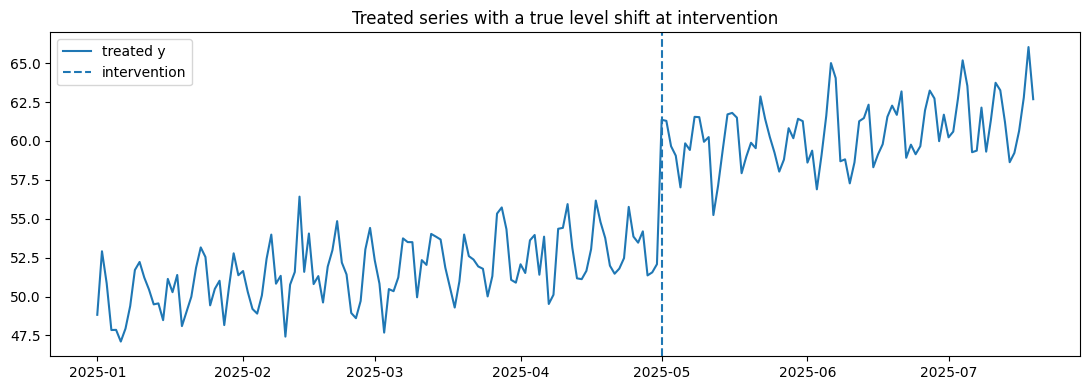

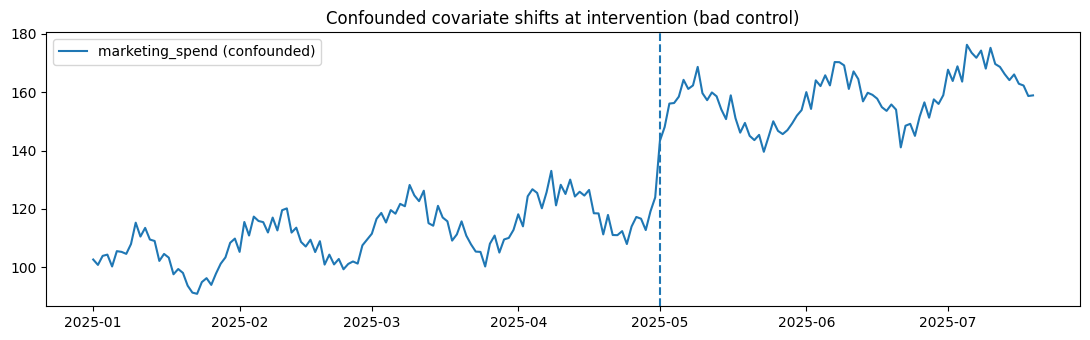

In [4]:
plt.figure(figsize=(11, 4))
plt.plot(df["date"], df["y"], label="treated y")
plt.axvline(intervention_date, linestyle="--", label="intervention")
plt.title("Treated series with a true level shift at intervention")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 3.5))
plt.plot(df["date"], df["marketing_spend"], label="marketing_spend (confounded)")
plt.axvline(intervention_date, linestyle="--")
plt.title("Confounded covariate shifts at intervention (bad control)")
plt.legend()
plt.tight_layout()
plt.show()

## 2) Fit two estimators
A) Impact-like regression counterfactual (covariates)

- Uses sessions, active_users, marketing_spend.
- Adds minimal time features (trend + day-of-week).

B) Synthetic Control (donor mode)

- Uses only donor series donor_* as controls.
- Typically disables extra time features to highlight donor matching.

In [5]:
cfg_common = dict(
    intervention_date=str(intervention_date.date()),
    ridge_alpha=1.0,
    bootstrap_iters=200,
    block_size=7,
    alpha=0.05,
    run_placebo=True,
    n_placebos=25,
    random_state=42,
    verbose=False,
)

# A) Impact-like (covariate regression)
spec_reg = DataSpec(
    date_col="date",
    y_col="y",
    x_cols=["sessions", "active_users", "marketing_spend"],
    freq="D",
    add_time_trend=True,
    add_day_of_week=True,
)
cfg_reg = ImpactConfig(method=ImpactMethod.CAUSAL_IMPACT_LIKE, **cfg_common)

# B) Synthetic control (donor mode)
donor_cols = [c for c in df.columns if c.startswith("donor_")]
spec_sc = DataSpec(
    date_col="date",
    y_col="y",
    x_cols=donor_cols,
    freq="D",
    add_time_trend=False,
    add_day_of_week=False,
)
cfg_sc = ImpactConfig(method=ImpactMethod.SYNTHETIC_CONTROL, **cfg_common)

res_reg = run_impact(df, spec_reg, cfg_reg)
res_sc  = run_impact(df, spec_sc, cfg_sc)

print("True daily level shift:", true_level_shift)
print("\nImpact-like (regression) summary:")
print(res_reg.summary())
print("\nSynthetic control (donor-mode) summary:")
print(res_sc.summary())

True daily level shift: 6.0

Impact-like (regression) summary:
{'method': 'causal_impact_like', 'intervention_date': '2025-05-01', 'point_effect': 5.978595792677115, 'point_ci': (5.705795851919767, 6.230723590572093), 'cum_effect': 478.28766341416923, 'cum_ci': (456.46366815358135, 498.4578872457674), 'rel_effect': 0.10948861840765389, 'rel_ci': (0.10449271474549357, 0.11410594414951077), 'p_value': 0.0, 'warnings': [], 'diagnostics': {'r2_pre': 0.6971296488359278, 'rmse_pre': 1.1215782323878378, 'acf_lag1': 0.03937305465088523, 'acf_lag2': 0.14929286618565907, 'acf_lag3': -0.13011140126419604, 'acf_lag4': 0.05176858819336159, 'acf_lag5': -0.09733413839881898, 'acf_lag6': -0.005666287489650452, 'acf_lag7': -0.21884227230900752, 'max_abs_acf_1_to_7': 0.21884227230900752}, 'economics': None}

Synthetic control (donor-mode) summary:
{'method': 'synthetic_control', 'intervention_date': '2025-05-01', 'point_effect': 5.697892784587308, 'point_ci': (5.4969229701753255, 5.898914780319659), 'cu

## 3) Compare counterfactuals and effects

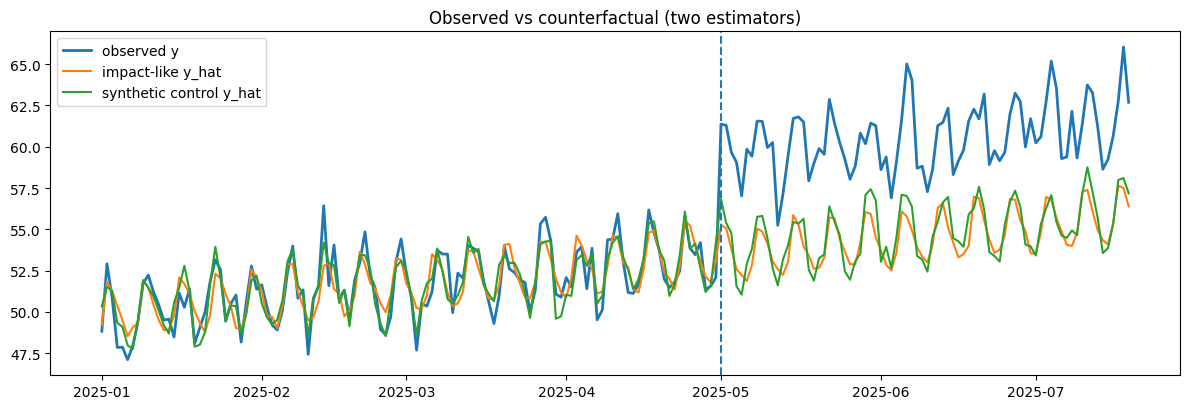

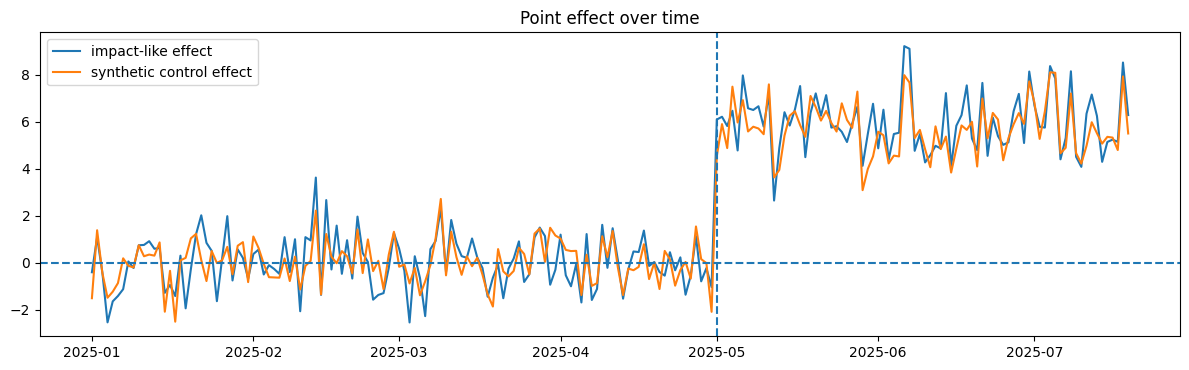

In [6]:
eff_reg = res_reg.effect_series.copy()
eff_sc = res_sc.effect_series.copy()

for eff in (eff_reg, eff_sc):
    eff["date"] = pd.to_datetime(eff["date"])

plt.figure(figsize=(12, 4.2))
plt.plot(eff_reg["date"], eff_reg["y"], label="observed y", linewidth=2)
plt.plot(eff_reg["date"], eff_reg["y_hat"], label="impact-like y_hat")
plt.plot(eff_sc["date"], eff_sc["y_hat"], label="synthetic control y_hat")
plt.axvline(intervention_date, linestyle="--")
plt.title("Observed vs counterfactual (two estimators)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3.8))
plt.plot(eff_reg["date"], eff_reg["effect"], label="impact-like effect")
plt.plot(eff_sc["date"], eff_sc["effect"], label="synthetic control effect")
plt.axhline(0.0, linestyle="--")
plt.axvline(intervention_date, linestyle="--")
plt.title("Point effect over time")
plt.legend()
plt.tight_layout()
plt.show()

## 4) Donor weights (interpretability)
In donor-mode, a key artifact is the set of donor weights / coefficients used to match the treated unit in the pre-period.

Computed ridge coefficients from pre-period (alpha=1.0), intercept=-3.342


,ridge_coef
donor_4,0.323595
donor_2,0.292987
donor_5,0.236845
donor_1,0.121594
donor_3,0.091412


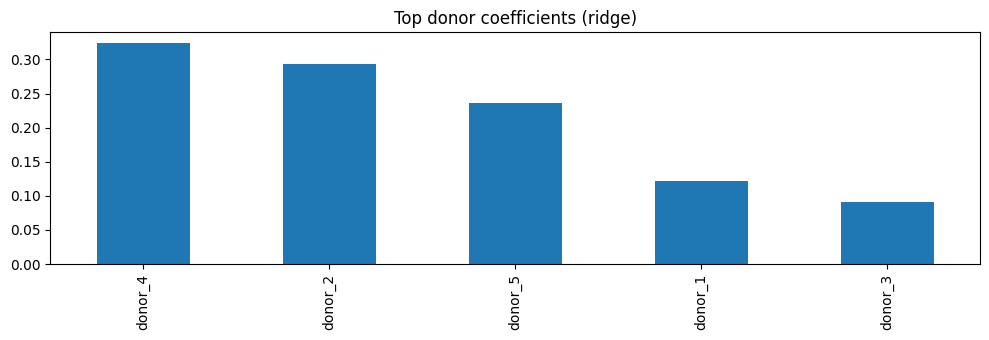

In [8]:
# 1) Try to find coefficients in diagnostics (if you ever decide to store them there)
diag = getattr(res_sc, "diagnostics", {}) or {}
model_sc = diag.get("model") or diag.get("ridge_model") or diag.get("synthetic_control_model")

coef = None
feature_names = donor_cols

if isinstance(model_sc, dict):
    coef = model_sc.get("coef")
    feature_names = model_sc.get("feature_names", donor_cols)

# 2) Fallback: compute ridge coefficients directly from the data (pre-period fit)
if coef is None:
    t0 = pd.Timestamp(cfg_sc.intervention_date)
    df_sorted = df.sort_values("date").copy()

    pre_mask = pd.to_datetime(df_sorted["date"]) < t0
    X_pre = df_sorted.loc[pre_mask, donor_cols].to_numpy(dtype=float)
    y_pre = df_sorted.loc[pre_mask, spec_sc.y_col].to_numpy(dtype=float)

    # Add intercept (not penalized)
    X1 = np.column_stack([np.ones(len(X_pre)), X_pre])

    alpha = float(getattr(cfg_sc, "ridge_alpha", 1.0))
    I = np.eye(X1.shape[1])
    I[0, 0] = 0.0  # do not penalize intercept

    beta = np.linalg.solve(X1.T @ X1 + alpha * I, X1.T @ y_pre)
    intercept = float(beta[0])
    coef = beta[1:]
    feature_names = donor_cols

    print(f"Computed ridge coefficients from pre-period (alpha={alpha}), intercept={intercept:.3f}")

# 3) Show weights / coefficients
w = pd.Series(np.asarray(coef, dtype=float), index=feature_names).sort_values(
    key=lambda s: s.abs(), ascending=False
)

display(w.head(10).to_frame("ridge_coef"))

plt.figure(figsize=(10, 3.5))
w.head(10).plot(kind="bar")
plt.title("Top donor coefficients (ridge)")
plt.tight_layout()
plt.show()

## Results summary

- **True effect (daily level shift):** `{true_level_shift:.2f}`
- **Impact-like (covariate regression):** point `{fmt(res_reg.point_effect)}`, cumulative `{fmt(res_reg.cum_effect)}`, relative `{fmt(res_reg.rel_effect)}`
- **Synthetic control (donor-mode):** point `{fmt(res_sc.point_effect)}`, cumulative `{fmt(res_sc.cum_effect)}`, relative `{fmt(res_sc.rel_effect)}`

**Interpretation**
- If the covariate `marketing_spend` shifts at the intervention date (confounding), regression-based counterfactuals can attribute part of that shift to the treatment.
- Donor-based synthetic control relies on untreated series to track common shocks and seasonality. When donors are valid and pre-fit is strong, it is often more robust to covariate confounding.

**Next checks**
- Inspect `res_sc.warnings` and placebo results for both estimators.
- Try sensitivity: remove the top-weight donor and re-fit (leave-one-donor-out).
"""

## Results summary

- True effect (daily level shift): 6.0
- Impact-like (covariate regression): point 5.98, cumulative 478.29, relative 0.109
- Synthetic control (donor-mode): point 5.61, cumulative 455.83, relative 0.104

### Interpretation
- If the covariate `marketing_spend` shifts at the intervention date (confounding), regression-based counterfactuals can attribute part of that shift to the treatment.
- Donor-based synthetic control relies on untreated series to track common shocks and seasonality. When donors are valid and pre-fit is strong, it is often more robust to covariate confounding.

### Next checks
- Inspect warnings and placebo results for both estimators.
- Try sensitivity: remove the top-weight donor and re-fit (leave-one-donor-out).